In [42]:
import numpy as np
import pandas as pd
import strategy_testing as st
import misc
import matplotlib.pyplot as plt
from misc import get_attr


In [3]:

spy_df = pd.read_csv('stock_price_data/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218227,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397591,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451382,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720436,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828062,531500,SPY
...,...,...,...,...,...,...,...,...
7577,2023-03-03,399.709991,404.450012,399.029999,404.190002,404.190002,90038300,SPY
7578,2023-03-06,405.049988,407.450012,404.010010,404.470001,404.470001,72795900,SPY
7579,2023-03-07,404.420013,404.670013,397.630005,398.269989,398.269989,108310600,SPY
7580,2023-03-08,398.390015,399.709991,396.589996,398.920013,398.920013,74746600,SPY


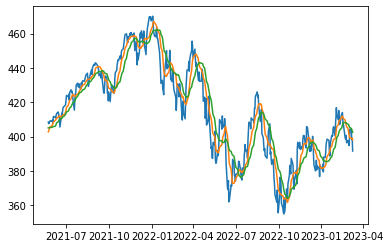

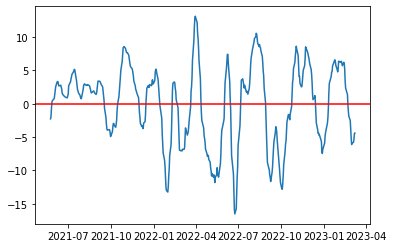

In [4]:


trade_list = []
df = spy_df.copy()
df = df.iloc[-471:]
df['ma1'] = df['adjclose'].rolling(10).mean()
df['ma2'] = df['adjclose'].rolling(20).mean()
df = df.dropna()
df['signal'] = df['ma1'] - df['ma2']


plt.plot(df['date'], df['adjclose'])
plt.plot(df['date'], df['ma1'])
plt.plot(df['date'], df['ma2'])
plt.show()

plt.plot(df['date'], df['signal'])
plt.axhline(0, color='red')
plt.show()



# for i in range(2, len(df)):

#     if df.iloc[i - 2]['signal'] < 0 and df.iloc[i - 1]['signal'] > 0:
        



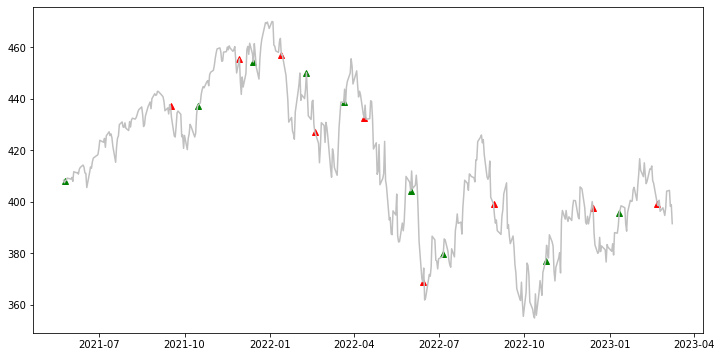

In [5]:
trade = df[['date', 'adjclose', 'signal']].copy()
trade['signal-1'] = trade['signal'].shift(-1)
trade['buy'] = None
trade['sell'] = None

trade['position'] = None
trade['position_value'] = None
trade['cash'] = None


position = 0


trade.loc[(trade['signal-1'] > 0) & (trade['signal'] < 0), 'buy'] = trade['adjclose']
trade.loc[(trade['signal-1'] < 0) & (trade['signal'] > 0), 'sell'] = trade['adjclose']


plt.figure(figsize=(12,6))
plt.plot(trade['date'], trade['buy'], marker='^', color='green', linestyle='None')
plt.plot(trade['date'], trade['sell'], marker='^', color='red', linestyle='None')
plt.plot(trade['date'], trade['adjclose'], color='silver')

plt.show()

In [6]:
trade

,date,adjclose,signal,signal-1,buy,sell,position,position_value,cash
7130,2021-05-24,408.385529,-2.279297,-1.921739,None,None,None,None,None
7131,2021-05-25,407.479401,-1.921739,-0.672237,None,None,None,None,None
7132,2021-05-26,408.288055,-0.672237,0.243089,408.288055,None,None,None,None
7133,2021-05-27,408.502380,0.243089,0.446709,None,None,None,None,None
7134,2021-05-28,409.233093,0.446709,0.779422,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
7577,2023-03-03,404.190002,-5.910999,-5.795999,None,None,None,None,None
7578,2023-03-06,404.470001,-5.795999,-5.300000,None,None,None,None,None
7579,2023-03-07,398.269989,-5.300000,-4.448500,None,None,None,None,None
7580,2023-03-08,398.920013,-4.448500,-4.404001,None,None,None,None,None


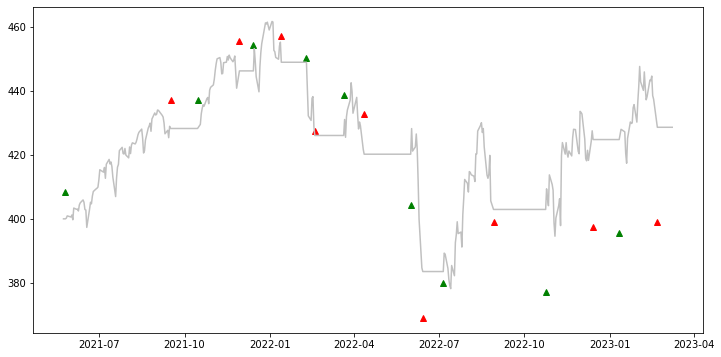

In [7]:
initial_capital = 1e6
cash = initial_capital
position = 0
position_value = 0



for i in range(len(trade)):

    if trade.loc[trade.index[i], 'buy'] is not None:
        quantity = cash // trade.loc[trade.index[i],'adjclose']
        position = quantity
        cash -= quantity * trade.loc[trade.index[i],'adjclose']
    
    if trade.loc[trade.index[i], 'sell'] is not None:
        quantity = position
        position = 0
        cash += quantity * trade.loc[trade.index[i],'adjclose']
    
    

    trade.loc[df.index[i], 'position'] = position
    trade.loc[df.index[i], 'cash'] = cash

trade['position_value'] = trade['adjclose'] * trade['position']
trade['portfolio_value'] = trade['cash'] + trade['position_value']

plt.figure(figsize=(12,6))
plt.plot(trade['date'], trade['buy'], marker='^', color='green', linestyle='None')
plt.plot(trade['date'], trade['sell'], marker='^', color='red', linestyle='None')
plt.plot(trade['date'], trade['portfolio_value'] * 400/1e6, color='silver')

plt.show()

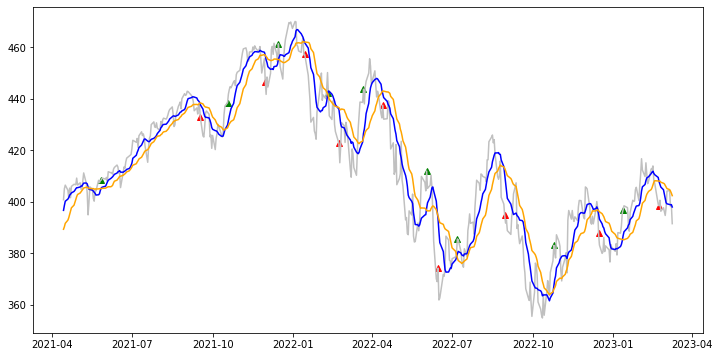

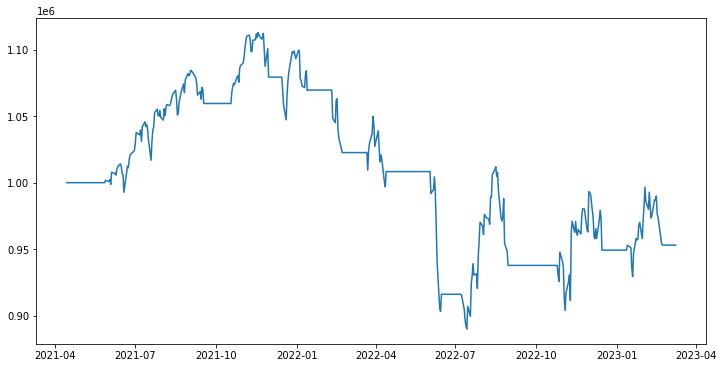

In [31]:


df = spy_df.copy()
df = df.iloc[-500:]
df['ma1'] = df['adjclose'].rolling(10).mean()
df['ma2'] = df['adjclose'].rolling(20).mean()

df['signal'] = df['adjclose'].rolling(10).mean() - df['adjclose'].rolling(20).mean()
df['signal+1'] = df['signal'].shift(1)
df = df.dropna()
df['cash'] = None
df['position'] = None
df['position_value'] = None
df['portfolio_value'] = None
df['margin'] = None
df['order_price'] = None
df['order_quantity'] = None

# input_arr = O, H, L, C, ADJC, V, S, S+1
# trader_state = cash, position, position_value, portfolio_value, margin


trader_state = np.array([1e6, 0, 0, 1e6, 0])
cash, position, position_value, portfolio_value, margin = trader_state

for i in range(len(df)):
    input_arr = df.loc[df.index[i], ['adjclose', 'signal', 'signal+1']]
    input_arr = np.array(input_arr)
    limit_order = ma_crossover(input_arr, trader_state)
    order_price = limit_order[0]
    order_quantity = limit_order[1]
    df.loc[df.index[i], 'order_price'] = order_price
    df.loc[df.index[i], 'order_quantity'] = order_quantity

    cash -= order_price * order_quantity
    position += order_quantity
    position_value = position * df.loc[df.index[i], 'adjclose']
    portfolio_value = cash + position_value
    if position_value != 0:
        margin = portfolio_value / abs(position_value)
    else:
        margin = None
    
    trader_state = (cash, position, position_value, portfolio_value, margin)

    df.loc[df.index[i], 'cash'] = cash
    df.loc[df.index[i], 'position'] = position
    df.loc[df.index[i], 'position_value'] = position_value
    df.loc[df.index[i], 'portfolio_value'] = portfolio_value
    df.loc[df.index[i], 'margin'] = margin


df['buy_order'] = df['order_price']
df['sell_order'] = df['order_price']
df.loc[df['order_quantity'] <= 0, 'buy_order'] = None
df.loc[df['order_quantity'] >= 0, 'sell_order'] = None

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['buy_order'], marker='^', color='green', linestyle='None')
plt.plot(df['date'], df['sell_order'], marker='^', color='red', linestyle='None')
plt.plot(df['date'], df['adjclose'], color='silver')
plt.plot(df['date'], df['ma1'], color='blue')
plt.plot(df['date'], df['ma2'], color='orange')

plt.show()

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['portfolio_value'])
plt.show()

c:\Users\alexr\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
c:\Users\alexr\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


           date        open        high         low       close    adjclose  \
7132 2021-05-26  418.869995  419.609985  417.760010  419.070007  408.288055   
7133 2021-05-27  420.170013  420.720001  418.989990  419.290009  408.502380   
7134 2021-05-28  420.970001  421.250000  419.790009  420.040009  409.233093   
7135 2021-06-01  422.570007  422.720001  419.200012  419.670013  408.872650   
7136 2021-06-02  420.369995  421.230011  419.290009  420.329987  409.515656   
...         ...         ...         ...         ...         ...         ...   
7577 2023-03-03  399.709991  404.450012  399.029999  404.190002  404.190002   
7578 2023-03-06  405.049988  407.450012  404.010010  404.470001  404.470001   
7579 2023-03-07  404.420013  404.670013  397.630005  398.269989  398.269989   
7580 2023-03-08  398.390015  399.709991  396.589996  398.920013  398.920013   
7581 2023-03-09  399.739990  401.480011  390.529999  391.559998  391.559998   

         volume ticker    signal  signal+1  order_p

C:\Users\alexr\AppData\Local\Temp\ipykernel_11016\1503987394.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['returns'] = np.insert(self.df['portfolio_value'].to_numpy()[1:] / self.df['portfolio_value'][:-1].to_numpy(), 0, 1)
C:\Users\alexr\AppData\Local\Temp\ipykernel_11016\1503987394.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['cumulative_returns'] = np.cumprod(self.df['returns'])


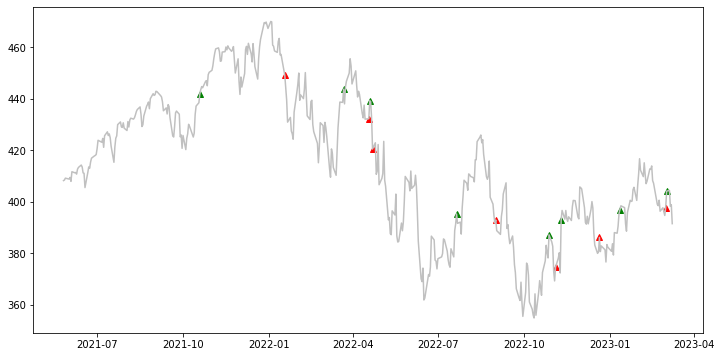

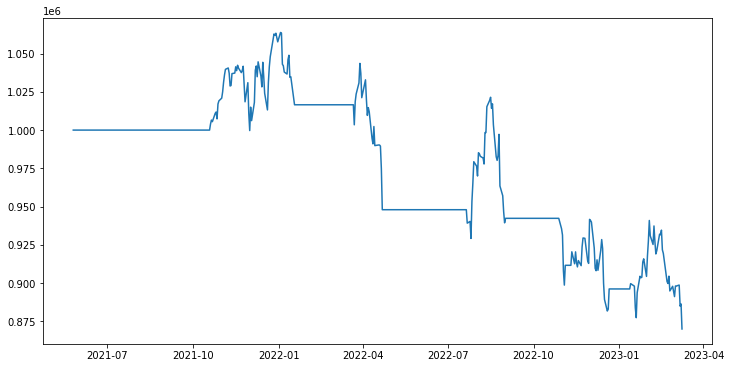

In [85]:
class tester:
    def __init__(self, signal_func, strategy_func, **kwargs):
        self.signal_func = signal_func
        self.strategy_func = strategy_func


    def generate_signal(self, data_df, **kwargs):
        '''
        Generate signal from data_df and
        appends the signals as extra columns in df.
        '''
        self.df = self.signal_func(data_df, **kwargs)
    
    def run_strategy(self, trader_state, **kwargs):
        '''
        Runs strategy based on signals in self.df
        '''

        df['cash'] = None
        df['position'] = None
        df['position_value'] = None
        df['portfolio_value'] = None
        df['margin'] = None
        df['order_price'] = None
        df['order_quantity'] = None

        # Specify what features/columns are used in the strategy
        strategy_input_features = get_attr(kwargs, 'strategy_input_features', None)
        if strategy_input_features == None:
            raise Exception('Must have strategy input features')

        # Specify initial trader_state, e.g. initial capital
        cash, position, position_value, portfolio_value, margin = trader_state

        for i in range(len(self.df)):
            # Specify input arr to strategy
            input_arr = np.array(self.df.loc[self.df.index[i], strategy_input_features])

            # Run strategy to generate limit_order
            limit_order = self.strategy_func(input_arr, trader_state, **kwargs)
            order_price, order_quantity = limit_order

            # Update trader_state
            cash -= order_price * order_quantity
            position += order_quantity
            position_value = position * self.df.loc[self.df.index[i], 'adjclose']
            portfolio_value = cash + position_value
            if position_value != 0:
                margin = portfolio_value / abs(position_value)
            else:
                margin = None
            
            trader_state = (cash, position, position_value, portfolio_value, margin)

            # Record values in df
            self.df.loc[self.df.index[i], 'order_price'] = order_price
            self.df.loc[self.df.index[i], 'order_quantity'] = order_quantity
            self.df.loc[self.df.index[i], 'cash'] = cash
            self.df.loc[self.df.index[i], 'position'] = position
            self.df.loc[self.df.index[i], 'position_value'] = position_value
            self.df.loc[self.df.index[i], 'portfolio_value'] = portfolio_value
            self.df.loc[self.df.index[i], 'margin'] = margin
        
        

    def evaluate_strategy(self, **kwargs):
        '''
        Generate key performance indicators
        1. Total Returns
        2. CAGR
        3. Volatility
        4. Sharpe Ratio
        5. Max Drawdown
        6. Calmar Ratio
        '''
        # returns
        self.df['returns'] = np.insert(self.df['portfolio_value'].to_numpy()[1:] / self.df['portfolio_value'][:-1].to_numpy(), 0, 1)
        # cumulative returns
        self.df['cumulative_returns'] = np.cumprod(self.df['returns'])
        
        print(self.df)
        

def ma_crossover(input_arr, trader_state, **kwargs):
    '''
    input_arr = ADJC, S, S+1
    trader_state = cash, position, position_value, portfolio_value, margin
    '''
    buy_threshold = get_attr(kwargs, 'buy_threshold', 0)
    sell_threshold = get_attr(kwargs, 'sell_threshold', 0)
    cash, position, _, _, _ = trader_state
    adjclose, signal, signal_1 = input_arr

    limit_order = np.zeros(2)
    if  signal > buy_threshold and signal_1 < buy_threshold:
        limit_order[0] = adjclose
        limit_order[1] = cash // adjclose
    elif signal < sell_threshold and signal_1 > sell_threshold:
        limit_order[0] = adjclose
        limit_order[1] = -position

    return limit_order

def ma_signal(df, **kwargs):
    
    
    short_period = get_attr(kwargs, 'short_period', 10)
    long_period = get_attr(kwargs, 'long_period', 20)

    df['signal'] = df['adjclose'].rolling(short_period).mean() - df['adjclose'].rolling(long_period).mean()
    df['signal+1'] = df['signal'].shift(1)
    df = df.dropna()

    return df

from misc import get_attr

df = spy_df.copy()
df = df.iloc[-500:]

test = tester(ma_signal, ma_crossover)
test.generate_signal(data_df=df, **{'short_period': 5, 'long_period': 50})
test.run_strategy(trader_state=np.array([1e6, 0, 0, 1e6, 0]), **{'buy_threshold': 0, 'sell_threshold': 0, 'strategy_input_features': ['adjclose', 'signal', 'signal+1']})
test.evaluate_strategy()

df = test.df
df['buy_order'] = df['order_price']
df['sell_order'] = df['order_price']
df.loc[df['order_quantity'] <= 0, 'buy_order'] = None
df.loc[df['order_quantity'] >= 0, 'sell_order'] = None

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['buy_order'], marker='^', color='green', linestyle='None')
plt.plot(df['date'], df['sell_order'], marker='^', color='red', linestyle='None')
plt.plot(df['date'], df['adjclose'], color='silver')

plt.show()

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['portfolio_value'])
plt.show()